In [2]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
pd.options.display.max_columns=None

import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import StandardScaler, Normalizer

In [3]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

In [36]:
home_history = pd.read_csv('../data/train_LSTM/home_history_full.csv', index_col = 0,\
    dtype={'home_id' : np.int32, 'game_id' : np.int32, 'H_goals' : np.int8, 'H_goals_conceded' : np.int8,\
         'H_HorA' : np.int8, 'H_yellow_cards' : np.int8, 'H_red_cards' : np.int8}\
    )

away_history = pd.read_csv('../data/train_LSTM/away_history_full.csv', index_col = 0,\
    dtype={'away_id' : np.int32, 'game_id' : np.int32, 'A_goals' : np.int8, 'A_goals_conceded' : np.int8,\
         'A_HorA' : np.int8, 'A_yellow_cards' : np.int8, 'A_red_cards' : np.int8}\
    )

In [37]:
game_history = pd.read_csv('../data/train_LSTM/game_history_full.csv', index_col = 0,\
    dtype={'game_history_id' : np.int32, 'game_id' : np.int32, 'H_goals' : np.int8, 'H_goals_conceded' : np.int8,\
         'H_HorA' : np.int8, 'H_yellow_cards' : np.int8, 'H_red_cards' : np.int8, 'A_yellow_cards' : np.int8, 'A_red_cards' : np.int8}\
    )

In [62]:
train_df = pd.read_csv('../data/training_data/train_final_6.csv', index_col = 0)
#train_df = train_df.astype(dtype={x:np.float32 for x in train_df.columns[1:-1]})
train_df.Home_result = train_df.Home_result.apply(lambda x: \
    0 if x>0 else( 1 if x==0 else 2 )\
    )


In [39]:
train_best = pd.read_csv( '../data/training_data/train_best_final_6.csv', index_col = 0)
train_best = train_best.astype(dtype={x:np.float16 for x in train_best.columns[1:]})

## selection des matchs dans game_history, away_history et game_history

In [40]:

# on rajoute des 0 et des 1 au début de chaque ligne pour indiquer si il y a un match ou pas
# on inverse le game_history avec np.flip(game_history,axis=1) pour classer les matches du plus ancien au plus récent
# Cela dit l'expérience montre que cette inversion n'a pas énormément d'impact sur les performances du modèle... 

def make_home_train(game_id):
    game_history = home_history.loc[home_history.game_id == game_id,:].drop(columns=['home_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)

def make_away_train(game_id):
    game_history = away_history.loc[away_history.game_id == game_id,:].drop(columns=['away_id','game_id'])
    if (n_lines := game_history.shape[0]) == 0:
        return np.zeros((10,6)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((10-n_lines,6)) , np.hstack(( np.ones((n_lines,1)) , np.flip(game_history.to_numpy(),axis=1))) )).astype(np.int8)

# on rajoute des 0 et des 1 au début de chaque ligne pour indiquer si il y a un match ou pas
# on inverse le game_history avec np.flip(game_history,axis=1) pour classer les matches du plus ancien au plus récent
# Cela dit l'expérience montre que cette inversion n'a pas énormément d'impact sur les performances du modèle... 

def make_history_train(game_id):
    encounter_history = game_history.loc[game_history.game_id == game_id,:].drop(columns=['game_history_id','game_id'])
    if (n_lines := encounter_history.shape[0]) == 0:
        return np.zeros((5,8)).astype(np.int8)
    else:
        return np.vstack(( np.zeros((5-n_lines,8)) , np.hstack(( np.ones((n_lines,1)) , np.flip(encounter_history.to_numpy(),axis=1))) )).astype(np.int8)


In [41]:
#ATTENTION: certaines parties apparaissent en double dans games.csv
tt = home_history.groupby('game_id')['home_id'].count().reset_index()
display(tt.loc[tt.home_id>10,:])
# ça nous casse les pieds on va s'en débarasser, il n'y en a que trois, on les jarte
home_history.drop(home_history.loc[home_history.game_id.isin( tt.loc[tt.home_id>10,'game_id'] ), :].index,inplace = True)


#idem pour away_history

tt = away_history.groupby('game_id')['away_id'].count().reset_index()
display(tt.loc[tt.away_id>10,:])
away_history.drop(away_history.loc[away_history.game_id.isin( tt.loc[tt.away_id>10,'game_id'] ), :].index,inplace = True)

#idem pour game_history

tt = game_history.groupby('game_id')['game_history_id'].count().reset_index()
display(tt.loc[tt.game_history_id>5,:])
game_history.drop(game_history.loc[game_history.game_id.isin( tt.loc[tt.game_history_id>5,'game_id'] ), :].index,inplace = True)



,game_id,home_id
37318,3631969,20
37427,3646046,20
37432,3646057,20


,game_id,away_id
38030,3631968,20
38141,3646046,20
38146,3646057,20


,game_id,game_history_id


In [42]:
game_ids = train_df.game_id.astype(np.int32)

train_home = game_ids.progress_apply(make_home_train)
train_home = np.stack(train_home.values)

train_away = game_ids.progress_apply(make_away_train)
train_away = np.stack(train_away.values)

train_history = game_ids.progress_apply(make_history_train)
train_history = np.stack(train_history.values)


100%|██████████| 30423/30423 [00:32<00:00, 923.80it/s] 


In [55]:
train_home.shape, train_away.shape, train_history.shape, train_best.shape, train_df.shape

((30423, 10, 6), (30423, 10, 6), (30423, 5, 8), (30423, 145), (30423, 194))

## Normalisation

In [72]:
train_df = pd.read_csv('../data/training_data/train_final_6.csv', index_col = 0)
#train_df = train_df.astype(dtype={x:np.float32 for x in train_df.columns[1:-1]})
train_df.Home_result = train_df.Home_result.apply(lambda x: \
    0 if x>0 else( 1 if x==0 else 2 )\
    )


In [73]:
col_list = [x+y for x in ['H_', 'A_'] for y in ['GK', 'attack', 'defense', 'midfield']]
col_list = col_list + [x + y + z for x in ['H_', 'A_'] for y in ['ATK_', 'DEF_', 'MF_'] for z in ['weak_foot', 'skill_moves', 'international_reputation']]
col_list2 = col_list + ['game_id', 'Home_result']

train_df.loc[:, [x for x in col_list]] = train_df.loc[:, [x for x in col_list]]/5.
train_df.loc[:, [x for x in train_df.columns if x not in col_list2]]=train_df.loc[:, [x for x in train_df.columns if x not in col_list]]/100.

In [80]:
train_best = pd.read_csv( '../data/training_data/train_best_final_6.csv', index_col = 0)
train_best = train_best.astype(dtype={x:np.float16 for x in train_best.columns[1:]})

In [81]:
col_list = [x + y + z for x in ['H_best_', 'A_best_'] for y in ['ATK_', 'DEF_', 'MF_'] for z in ['weak_foot', 'skill_moves', 'international_reputation']]
col_list2 = col_list + ['game_id']

train_best.loc[:, col_list] = train_best.loc[:, col_list]/5.

,game_id,H_best_ATK_overall,H_best_ATK_potential,H_best_ATK_weak_foot,H_best_ATK_skill_moves,H_best_ATK_international_reputation,H_best_ATK_pace,H_best_ATK_shooting,H_best_ATK_passing,H_best_ATK_dribbling,H_best_ATK_defending,H_best_ATK_physic,H_best_ATK_attacking_crossing,H_best_ATK_attacking_heading_accuracy,H_best_ATK_skill_curve,H_best_ATK_skill_fk_accuracy,H_best_ATK_movement_agility,H_best_ATK_movement_reactions,H_best_ATK_movement_balance,H_best_ATK_power_shot_power,H_best_ATK_power_jumping,H_best_ATK_power_stamina,H_best_ATK_mentality_aggression,H_best_ATK_mentality_positioning,H_best_ATK_mentality_penalties,H_best_DEF_overall,H_best_DEF_potential,H_best_DEF_weak_foot,H_best_DEF_skill_moves,H_best_DEF_international_reputation,H_best_DEF_pace,H_best_DEF_shooting,H_best_DEF_passing,H_best_DEF_dribbling,H_best_DEF_defending,H_best_DEF_physic,H_best_DEF_attacking_crossing,H_best_DEF_attacking_heading_accuracy,H_best_DEF_skill_curve,H_best_DEF_skill_fk_accuracy,H_best_DEF_movement_agility,H_best_DEF_movement_reactions,H_best_DEF_movement_balance,H_best_DEF_power_shot_power,H_best_DEF_power_jumping,H_best_DEF_power_stamina,H_best_DEF_mentality_aggression,H_best_DEF_mentality_positioning,H_best_DEF_mentality_penalties,H_best_MF_overall,H_best_MF_potential,H_best_MF_weak_foot,H_best_MF_skill_moves,H_best_MF_international_reputation,H_best_MF_pace,H_best_MF_shooting,H_best_MF_passing,H_best_MF_dribbling,H_best_MF_defending,H_best_MF_physic,H_best_MF_attacking_crossing,H_best_MF_attacking_heading_accuracy,H_best_MF_skill_curve,H_best_MF_skill_fk_accuracy,H_best_MF_movement_agility,H_best_MF_movement_reactions,H_best_MF_movement_balance,H_best_MF_power_shot_power,H_best_MF_power_jumping,H_best_MF_power_stamina,H_best_MF_mentality_aggression,H_best_MF_mentality_positioning,H_best_MF_mentality_penalties,A_best_ATK_overall,A_best_ATK_potential,A_best_ATK_weak_foot,A_best_ATK_skill_moves,A_best_ATK_international_reputation,A_best_ATK_pace,A_best_ATK_shooting,A_best_ATK_passing,A_best_ATK_dribbling,A_best_ATK_defending,A_best_ATK_physic,A_best_ATK_attacking_crossing,A_best_ATK_attacking_heading_accuracy,A_best_ATK_skill_curve,A_best_ATK_skill_fk_accuracy,A_best_ATK_movement_agility,A_best_ATK_movement_reactions,A_best_ATK_movement_balance,A_best_ATK_power_shot_power,A_best_ATK_power_jumping,A_best_ATK_power_stamina,A_best_ATK_mentality_aggression,A_best_ATK_mentality_positioning,A_best_ATK_mentality_penalties,A_best_DEF_overall,A_best_DEF_potential,A_best_DEF_weak_foot,A_best_DEF_skill_moves,A_best_DEF_international_reputation,A_best_DEF_pace,A_best_DEF_shooting,A_best_DEF_passing,A_best_DEF_dribbling,A_best_DEF_defending,A_best_DEF_physic,A_best_DEF_attacking_crossing,A_best_DEF_attacking_heading_accuracy,A_best_DEF_skill_curve,A_best_DEF_skill_fk_accuracy,A_best_DEF_movement_agility,A_best_DEF_movement_reactions,A_best_DEF_movement_balance,A_best_DEF_power_shot_power,A_best_DEF_power_jumping,A_best_DEF_power_stamina,A_best_DEF_mentality_aggression,A_best_DEF_mentality_positioning,A_best_DEF_mentality_penalties,A_best_MF_overall,A_best_MF_potential,A_best_MF_weak_foot,A_best_MF_skill_moves,A_best_MF_international_reputation,A_best_MF_pace,A_best_MF_shooting,A_best_MF_passing,A_best_MF_dribbling,A_best_MF_defending,A_best_MF_physic,A_best_MF_attacking_crossing,A_best_MF_attacking_heading_accuracy,A_best_MF_skill_curve,A_best_MF_skill_fk_accuracy,A_best_MF_movement_agility,A_best_MF_movement_reactions,A_best_MF_movement_balance,A_best_MF_power_shot_power,A_best_MF_power_jumping,A_best_MF_power_stamina,A_best_MF_mentality_aggression,A_best_MF_mentality_positioning,A_best_MF_mentality_penalties
0,2457642,64.0,73.0,0.799805,0.600098,0.199951,75.0,59.0,63.0,68.0,27.0,52.0,65.0,44.0,68.0,44.0,66.0,40.0,70.0,63.0,40.0,65.0,68.0,57.0,60.0,67.0,67.0,0.600098,0.399902,0.199951,74.0,47.0,57.0,66.0,67.0,67.0,56.0,57.0,41.0,36.0,64.0,66.0,69.0,44.0,71.0,75.0,58.0,53.0,61.0,73.0,79.0,0.600098,0.600098,0.199951,70.0,56.0,68.0,74.0,66.0,69.0,57.0,41.

In [82]:
train_best.loc[:, [x for x in train_best.columns if x not in col_list2]] = train_best.loc[:, [x for x in train_best.columns if x not in col_list2]]/100.
train_best.head()

,game_id,H_best_ATK_overall,H_best_ATK_potential,H_best_ATK_weak_foot,H_best_ATK_skill_moves,H_best_ATK_international_reputation,H_best_ATK_pace,H_best_ATK_shooting,H_best_ATK_passing,H_best_ATK_dribbling,H_best_ATK_defending,H_best_ATK_physic,H_best_ATK_attacking_crossing,H_best_ATK_attacking_heading_accuracy,H_best_ATK_skill_curve,H_best_ATK_skill_fk_accuracy,H_best_ATK_movement_agility,H_best_ATK_movement_reactions,H_best_ATK_movement_balance,H_best_ATK_power_shot_power,H_best_ATK_power_jumping,H_best_ATK_power_stamina,H_best_ATK_mentality_aggression,H_best_ATK_mentality_positioning,H_best_ATK_mentality_penalties,H_best_DEF_overall,H_best_DEF_potential,H_best_DEF_weak_foot,H_best_DEF_skill_moves,H_best_DEF_international_reputation,H_best_DEF_pace,H_best_DEF_shooting,H_best_DEF_passing,H_best_DEF_dribbling,H_best_DEF_defending,H_best_DEF_physic,H_best_DEF_attacking_crossing,H_best_DEF_attacking_heading_accuracy,H_best_DEF_skill_curve,H_best_DEF_skill_fk_accuracy,H_best_DEF_movement_agility,H_best_DEF_movement_reactions,H_best_DEF_movement_balance,H_best_DEF_power_shot_power,H_best_DEF_power_jumping,H_best_DEF_power_stamina,H_best_DEF_mentality_aggression,H_best_DEF_mentality_positioning,H_best_DEF_mentality_penalties,H_best_MF_overall,H_best_MF_potential,H_best_MF_weak_foot,H_best_MF_skill_moves,H_best_MF_international_reputation,H_best_MF_pace,H_best_MF_shooting,H_best_MF_passing,H_best_MF_dribbling,H_best_MF_defending,H_best_MF_physic,H_best_MF_attacking_crossing,H_best_MF_attacking_heading_accuracy,H_best_MF_skill_curve,H_best_MF_skill_fk_accuracy,H_best_MF_movement_agility,H_best_MF_movement_reactions,H_best_MF_movement_balance,H_best_MF_power_shot_power,H_best_MF_power_jumping,H_best_MF_power_stamina,H_best_MF_mentality_aggression,H_best_MF_mentality_positioning,H_best_MF_mentality_penalties,A_best_ATK_overall,A_best_ATK_potential,A_best_ATK_weak_foot,A_best_ATK_skill_moves,A_best_ATK_international_reputation,A_best_ATK_pace,A_best_ATK_shooting,A_best_ATK_passing,A_best_ATK_dribbling,A_best_ATK_defending,A_best_ATK_physic,A_best_ATK_attacking_crossing,A_best_ATK_attacking_heading_accuracy,A_best_ATK_skill_curve,A_best_ATK_skill_fk_accuracy,A_best_ATK_movement_agility,A_best_ATK_movement_reactions,A_best_ATK_movement_balance,A_best_ATK_power_shot_power,A_best_ATK_power_jumping,A_best_ATK_power_stamina,A_best_ATK_mentality_aggression,A_best_ATK_mentality_positioning,A_best_ATK_mentality_penalties,A_best_DEF_overall,A_best_DEF_potential,A_best_DEF_weak_foot,A_best_DEF_skill_moves,A_best_DEF_international_reputation,A_best_DEF_pace,A_best_DEF_shooting,A_best_DEF_passing,A_best_DEF_dribbling,A_best_DEF_defending,A_best_DEF_physic,A_best_DEF_attacking_crossing,A_best_DEF_attacking_heading_accuracy,A_best_DEF_skill_curve,A_best_DEF_skill_fk_accuracy,A_best_DEF_movement_agility,A_best_DEF_movement_reactions,A_best_DEF_movement_balance,A_best_DEF_power_shot_power,A_best_DEF_power_jumping,A_best_DEF_power_stamina,A_best_DEF_mentality_aggression,A_best_DEF_mentality_positioning,A_best_DEF_mentality_penalties,A_best_MF_overall,A_best_MF_potential,A_best_MF_weak_foot,A_best_MF_skill_moves,A_best_MF_international_reputation,A_best_MF_pace,A_best_MF_shooting,A_best_MF_passing,A_best_MF_dribbling,A_best_MF_defending,A_best_MF_physic,A_best_MF_attacking_crossing,A_best_MF_attacking_heading_accuracy,A_best_MF_skill_curve,A_best_MF_skill_fk_accuracy,A_best_MF_movement_agility,A_best_MF_movement_reactions,A_best_MF_movement_balance,A_best_MF_power_shot_power,A_best_MF_power_jumping,A_best_MF_power_stamina,A_best_MF_mentality_aggression,A_best_MF_mentality_positioning,A_best_MF_mentality_penalties
0,2457642,0.640137,0.729980,0.799805,0.600098,0.199951,0.750000,0.589844,0.629883,0.680176,0.270020,0.520020,0.649902,0.439941,0.680176,0.439941,0.660156,0.399902,0.700195,0.629883,0.399902,0.649902,0.680176,0.569824,0.600098,0.669922,0.669922,0.600098,0.399902,0.199951,0.740234,0.469971,0.569824,0.660156,0.669922,0.669922,0.560059,0.569824,0.4099

## préparons les données pour l'entrainement du modèle

In [83]:
train_home = train_home.astype(np.float16)
train_away = train_away.astype(np.float16)
train_history = train_history.astype(np.float16)

In [84]:
y = train_df.Home_result.values
best_players = train_best.drop(columns=['game_id']).to_numpy()
players = train_df.drop(columns = ['game_id', 'Home_result']).to_numpy()
XH_train, XH_test, XA_train, XA_test, XG_train, XG_test, best_train, best_test, players_train, players_test, y_train, y_test = \
    train_test_split(train_home, train_away, train_history, best_players, players, y, test_size = 0.2, random_state=0, stratify=y)

In [85]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, xh_data, xa_data, xg_data, xbest_data, xplayer_data, y_data, batch_size):
    self.xh,self.xa, self.xg, self.xbest, self.xplayers, self.y = \
        xh_data, xa_data, xg_data, xbest_data, xplayer_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(xh_data) / batch_size)
    self.batch_idx = np.array_split(range(len(xh_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_xh = self.xh[self.batch_idx[idx]]
    batch_xa = self.xa[self.batch_idx[idx]]
    batch_xg = self.xg[self.batch_idx[idx]]
    batch_xbest = self.xbest[self.batch_idx[idx]]
    batch_xplayers = self.xplayers[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    return [batch_xh, batch_xa, batch_xg, batch_xplayers, batch_xbest], batch_y

train_generator = DataGenerator(XH_train, XA_train, XG_train, best_train, players_train, y_train, batch_size = 128)
val_generator =   DataGenerator(XH_test,  XA_test,  XG_test,  best_test,  players_test,  y_test,  batch_size = 32)


In [86]:
class DataGenerator2(tf.keras.utils.Sequence):
  def __init__(self, xh_data, xa_data, xg_data, xplayer_data, y_data, batch_size):
    self.xh,self.xa, self.xg, self.xplayers, self.y = \
        xh_data, xa_data, xg_data, xplayer_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(xh_data) / batch_size)
    self.batch_idx = np.array_split(range(len(xh_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_xh = self.xh[self.batch_idx[idx]].astype(np.float32)
    batch_xa = self.xa[self.batch_idx[idx]].astype(np.float32)
    batch_xg = self.xg[self.batch_idx[idx]].astype(np.float32)
    batch_xplayers = self.xplayers[self.batch_idx[idx]].astype(np.float32)
    batch_y = self.y[self.batch_idx[idx]].astype(np.float32)
    return [batch_xh, batch_xa, batch_xg, batch_xplayers], batch_y

train_generator2 = DataGenerator2(XH_train, XA_train, XG_train, players_train, y_train, batch_size = 128)
val_generator2 =   DataGenerator2(XH_test,  XA_test,  XG_test,  players_test,  y_test,  batch_size = 32)

# Modèle

In [87]:
from tensorflow.keras.regularizers import L1L2
LSTM_model = tf.keras.models.load_model('../data/models/H_A_game_history_LSTM')

In [ ]:
players_train.shape

In [ ]:

home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')                                   #input 1
home_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'home_LSTM_1')(home_input)

away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                   #input 2
away_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'away_LSTM_1')(away_input)

h_a = tf.keras.layers.Concatenate()([home_LSTM_1,away_LSTM_1])
h_a = tf.keras.layers.Dropout(0.234375)(h_a)
Dense1 = tf.keras.layers.Dense(64,'relu',name='Dense1')(h_a)
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)
Dense2 = tf.keras.layers.Dense(16,'relu',name='Dense2')(Dense1)
Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)


game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'game_LSTM_1')(game_input)


h_a_g = tf.keras.layers.Concatenate()([Dense2,game_LSTM_1])
Dense3 = tf.keras.layers.Dense(64,'relu',name='Dense3')(h_a_g)
Dense3 = tf.keras.layers.Dropout(0.125)(Dense3)

#players
player_input = tf.keras.Input(shape = (192), name = 'player_input')  
Dense4 = tf.keras.layers.Dense(64,'relu',name='Dense4')(player_input)
Dense4 = tf.keras.layers.Dropout(0.2)(Dense4)

#final concat

h_a_g_p = tf.keras.layers.Concatenate()([Dense3,Dense4])
Dense5 = tf.keras.layers.Dense(100,'relu',name='Dense5')(h_a_g_p)
Dense5 = tf.keras.layers.Dropout(0.2)(Dense5)

Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense5)

In [140]:

home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')                                   #input 1
home_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'home_LSTM_1')(home_input)

away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                   #input 2
away_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'away_LSTM_1')(away_input)

h_a = tf.keras.layers.Concatenate()([home_LSTM_1,away_LSTM_1])
h_a = tf.keras.layers.Dropout(0.234375)(h_a)
Dense1 = tf.keras.layers.Dense(64,'relu',name='Dense1')(h_a)
Dense1 = tf.keras.layers.Dropout(0.234375)(Dense1)
#Dense2 = tf.keras.layers.Dense(16,'relu',name='Dense2')(Dense1)
#Dense2 = tf.keras.layers.Dropout(0.125)(Dense2)


game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.02), name = 'game_LSTM_1')(game_input)


h_a_g = tf.keras.layers.Concatenate()([Dense1,game_LSTM_1])
Dense3 = tf.keras.layers.Dense(64,'relu',name='Dense3')(h_a_g)
Dense3 = tf.keras.layers.Dropout(0.125)(Dense3)

#players
player_input = tf.keras.Input(shape = (192), name = 'player_input')  
Dense4 = tf.keras.layers.Dense(64,'relu',name='Dense4')(player_input)
Dense4 = tf.keras.layers.Dropout(0.2)(Dense4)

#final concat

h_a_g_p = tf.keras.layers.Concatenate()([Dense3,Dense4])
Dense5 = tf.keras.layers.Dense(64,'relu',name='Dense5')(h_a_g_p)
Dense5 = tf.keras.layers.Dropout(0.2)(Dense5)

Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense5)

In [228]:

home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')                                   #input 1
home_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'home_LSTM_1')(home_input)

away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                   #input 2
away_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'away_LSTM_1')(away_input)

game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.01, l2=0.01), name = 'game_LSTM_1')(game_input)


h_a_g = tf.keras.layers.Concatenate()([h_a,game_LSTM_1])

#players
player_input = tf.keras.Input(shape = (192), name = 'player_input')  
Dense1 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense1')(player_input)
Dense1 = tf.keras.layers.Dropout(0.2)(Dense1)

#best_players

#final concat

h_a_g_p = tf.keras.layers.Concatenate()([h_a_g,Dense1])
Dense4 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense4')(h_a_g_p)
Dense4 = tf.keras.layers.Dropout(0.2)(Dense4)



Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense4)

In [229]:
model_1 = tf.keras.Model(inputs=[home_input,away_input,game_input,player_input], outputs=Dense_output)

In [230]:
opt = Adam(0.0001)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
model_1.compile(optimizer=opt, loss=loss, metrics = [metric])

In [212]:
print([x.name for x in model_1.layers])
print([x.name for x in LSTM_model.layers])

['player_input', 'Dense5', 'dropout_61', 'home_train_input', 'away_train_input', 'game_train_input', 'output']
['home_train_input', 'away_train_input', 'home_LSTM_1', 'away_LSTM_1', 'concatenate_66', 'dropout_167', 'Dense1', 'dropout_168', 'Dense2', 'game_train_input', 'dropout_169', 'game_LSTM_1', 'concatenate_67', 'Dense3', 'dropout_170', 'output']


In [231]:
#on va chercher les poids du modèle déjà entrainé
model_1.layers[2].set_weights(LSTM_model.layers[2].get_weights())
model_1.layers[3].set_weights(LSTM_model.layers[3].get_weights())
model_1.layers[7].set_weights(LSTM_model.layers[11].get_weights())
#model_1.layers[8].set_weights(LSTM_model.layers[8].get_weights())
#model_1.layers[9].set_weights(LSTM_model.layers[11].get_weights())
#model_1.layers[11].set_weights(LSTM_model.layers[11].get_weights())
#model_1.layers[12].set_weights(LSTM_model.layers[13].get_weights())




In [ ]:
class_weight = {0: 1.,
                1: 1,
                2: 1.}

In [232]:
wandb.init(project="foot_LSTM_AVGplayers", entity="padda")


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
loss,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▂▁▂▄▅▅▆▆▆▆▇▇▆▆▇▇▇▇█▇▇█▇█▇▇▇▇▇▆▇█▇▇▇▇▇▇▇
val_loss,█▄▄▄▃▂▂▂▃▂▃▁▁▁▂▁▁▁▂▁▁▂▂▁▁▄▁▂▂▂▂▂▁▁▁▂▂▂▁▁
val_sparse_categorical_accuracy,▂▂▃▁▃▅▆▇▃▆▄▇█▇▄▇▇▇▅▆▇▅▅▇█▁█▅▅▅▇▃▆▆█▆▃▅▇▇
best_epoch,49
best_val_loss,0.99167
epoch,199
loss,1.00017
sparse_categorical_accuracy,0.53102
val_loss,0.99674


In [246]:
#wandb.init(project="foot_LSTM_AVGplayers", entity="padda")
model_1.fit(
    train_generator2,
    epochs=100,
    validation_data=val_generator2,
    callbacks=[WandbCallback()])

Epoch 1/100
191/191 [==============================] - 3s 14ms/step - loss: 0.9889 - sparse_categorical_accuracy: 0.5406 - val_loss: 0.9870 - val_sparse_categorical_accuracy: 0.5371
Epoch 2/100
191/191 [==============================] - 2s 13ms/step - loss: 0.9905 - sparse_categorical_accuracy: 0.5350 - val_loss: 0.9888 - val_sparse_categorical_accuracy: 0.5343
Epoch 3/100
191/191 [==============================] - 2s 13ms/step - loss: 0.9900 - sparse_categorical_accuracy: 0.5396 - val_loss: 0.9891 - val_sparse_categorical_accuracy: 0.5353
Epoch 4/100
191/191 [==============================] - 2s 13ms/step - loss: 0.9886 - sparse_categorical_accuracy: 0.5373 - val_loss: 0.9866 - val_sparse_categorical_accuracy: 0.5390
Epoch 5/100
191/191 [==============================] - 2s 13ms/step - loss: 0.9884 - sparse_categorical_accuracy: 0.5383 - val_loss: 0.9862 - val_sparse_categorical_accuracy: 0.5382
Epoch 6/100
191/191 [==============================] - 3s 13ms/step - loss: 0.9890 - spars

/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_38439/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_38439/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.5375513557929334
Recall: 
 {0: 0.8268667642752562, 1: 0.0, 2: 0.5408872260823089} 
Precision: 
 {0: 0.5535407988238177, 1: nan, 2: 0.5049900199600799} 
F1-score: 
 {0: 0.6631439894319683, 1: nan, 2: 0.5223225806451612}


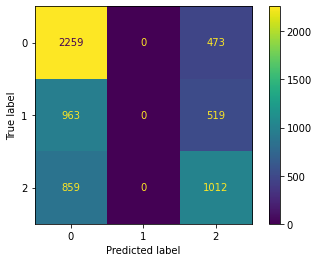

/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_38439/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_38439/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.5477031802120141
Recall: 
 {0: 0.8249611126361057, 1: 0.0, 2: 0.5766608742146772} 
Precision: 
 {0: 0.5602783992045737, 1: nan, 2: 0.5231627455736114} 
F1-score: 
 {0: 0.6673328152177935, 1: nan, 2: 0.5486106695491829}


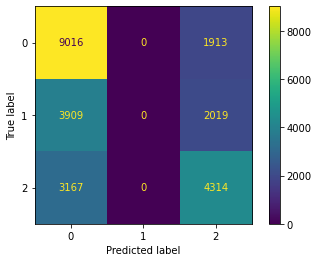

In [248]:
y_test_pred = model_1.predict([XH_test, XA_test, XG_test, players_test]).argmax(axis=-1)
y_train_pred = model_1.predict([XH_train, XA_train, XG_train, players_train]).argmax(axis=-1)


cm_metrics(y_test,y_test_pred, [0,1,2])
cm_metrics(y_train,y_train_pred, [0,1,2])

In [254]:
model_1.save('data/models/H_A_G_P_reg')

2022-01-25 00:33:16.089118: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/models/H_A_G_P_reg/assets


INFO:tensorflow:Assets written to: data/models/H_A_G_P_reg/assets


# Modèle 2

In [ ]:
from tensorflow.keras.regularizers import L1L2
LSTM_model = tf.keras.models.load_model('../data/models/H_A_game_history_LSTM')

In [112]:

home_input = tf.keras.Input(shape = (10,6) , name = 'home_train_input')                                   #input 1
home_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.001), name = 'home_LSTM_1')(home_input)

away_input = tf.keras.Input(shape = (10,6), name = 'away_train_input')                                   #input 2
away_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.001), name = 'away_LSTM_1')(away_input)

game_input = tf.keras.Input(shape = (5,8), name = 'game_train_input')                                   #input 3
game_LSTM_1 = tf.keras.layers.LSTM(32, kernel_regularizer = L1L2(l1=0.001, l2=0.001), name = 'game_LSTM_1')(game_input)

h_a_g = tf.keras.layers.Concatenate()([home_LSTM_1, away_LSTM_1, game_LSTM_1])
Dense0 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense0')(h_a_g)
Dense0 = tf.keras.layers.Dropout(0.2)(Dense0)



#players
player_input = tf.keras.Input(shape = (192), name = 'player_input')  
Dense1 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense1')(player_input)
Dense1 = tf.keras.layers.Dropout(0.2)(Dense1)


#best_players
best_player_input = tf.keras.Input(shape = (144), name = 'best_player_input')  
Dense2 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense2')(best_player_input)
Dense2 = tf.keras.layers.Dropout(0.2)(Dense2)


#final concat

h_a_g_p = tf.keras.layers.Concatenate()([Dense0, Dense1, Dense2])
Dense3 = tf.keras.layers.Dense(128,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense3')(h_a_g_p)
Dense3 = tf.keras.layers.Dropout(0.2)(Dense3)



Dense_output = tf.keras.layers.Dense(3, 'softmax', name='output')(Dense3)

In [113]:
model_2 = tf.keras.Model(inputs=[home_input,away_input,game_input,player_input,best_player_input], outputs=Dense_output)

opt = Adam(0.00005)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
model_2.compile(optimizer=opt, loss=loss, metrics = [metric])

In [116]:
print([x.name for x in model_2.layers])
print()
print([x.name for x in LSTM_model.layers])
print()
print(model_2.layers[3].name, model_2.layers[4].name, model_2.layers[5].name)

['home_train_input', 'away_train_input', 'game_train_input', 'home_LSTM_1', 'away_LSTM_1', 'game_LSTM_1', 'concatenate_3', 'player_input', 'best_player_input', 'Dense0', 'Dense1', 'Dense2', 'dropout_9', 'dropout_10', 'dropout_11', 'concatenate_4', 'Dense3', 'dropout_12', 'output']

['home_train_input', 'away_train_input', 'home_LSTM_1', 'away_LSTM_1', 'concatenate_66', 'dropout_167', 'Dense1', 'dropout_168', 'Dense2', 'game_train_input', 'dropout_169', 'game_LSTM_1', 'concatenate_67', 'Dense3', 'dropout_170', 'output']

home_LSTM_1 away_LSTM_1 game_LSTM_1


In [117]:
model_2.layers[3].set_weights(LSTM_model.layers[2].get_weights())
model_2.layers[4].set_weights(LSTM_model.layers[3].get_weights())
model_2.layers[5].set_weights(LSTM_model.layers[11].get_weights())


In [118]:
wandb.init(project="foot_LSTM_AVGplayers", entity="padda")

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,██▇▇█▇▆▇▆▇▅▆▅▆▅▅▅▄▅▄▄▄▄▄▄▄▄▂▃▃▃▃▃▁▂▂▁▁▁▂
sparse_categorical_accuracy,▂▂▁▄▂▁▄▃▄▂▄▃▄▄▅▃▄▅▅▆▃▅▄▅▄▄▅▆▄▄▆▆▇█▇▆▅█▇▇
val_loss,▆▇▆▅▄▆▆▆▄▅▅▄▄▃▄▄▄▃▄▃█▂▃▄▃▃▃▃▁▄▃▃▃▂▂▂▄▃▂▂
val_sparse_categorical_accuracy,▃▅▁▄▃▃▂▂▅▄▅▄▄▅▃▄▆▅▅▆▂▅▆▃▄▄▅▅█▆▆▄▃▃▄▄▄▇▄▅
best_epoch,387
best_val_loss,0.99389
epoch,499
loss,0.98813
sparse_categorical_accuracy,0.53386
val_loss,0.99541


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [119]:
model_2.fit(
    train_generator,
    epochs=500,
    validation_data=val_generator,
    callbacks=[WandbCallback()]
)

Epoch 1/500
191/191 [==============================] - 14s 39ms/step - loss: 5.2791 - sparse_categorical_accuracy: 0.4178 - val_loss: 5.0334 - val_sparse_categorical_accuracy: 0.4490
Epoch 2/500
191/191 [==============================] - 4s 22ms/step - loss: 4.8429 - sparse_categorical_accuracy: 0.4442 - val_loss: 4.6257 - val_sparse_categorical_accuracy: 0.4486
Epoch 3/500
191/191 [==============================] - 4s 21ms/step - loss: 4.4417 - sparse_categorical_accuracy: 0.4561 - val_loss: 4.2395 - val_sparse_categorical_accuracy: 0.4613
Epoch 4/500
191/191 [==============================] - 3s 18ms/step - loss: 4.0685 - sparse_categorical_accuracy: 0.4787 - val_loss: 3.8797 - val_sparse_categorical_accuracy: 0.4986
Epoch 5/500
191/191 [==============================] - 3s 17ms/step - loss: 3.7264 - sparse_categorical_accuracy: 0.4976 - val_loss: 3.5593 - val_sparse_categorical_accuracy: 0.5044
Epoch 6/500
191/191 [==============================] - 3s 15ms/step - loss: 3.4198 - spar

In [120]:
model_2.fit(
    train_generator,
    epochs=500,
    validation_data=val_generator,
    callbacks=[WandbCallback()]
)

Epoch 1/500
191/191 [==============================] - 3s 16ms/step - loss: 1.0059 - sparse_categorical_accuracy: 0.5312 - val_loss: 1.0021 - val_sparse_categorical_accuracy: 0.5292
Epoch 2/500
191/191 [==============================] - 2s 12ms/step - loss: 1.0063 - sparse_categorical_accuracy: 0.5303 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.5293
Epoch 3/500
191/191 [==============================] - 2s 12ms/step - loss: 1.0040 - sparse_categorical_accuracy: 0.5298 - val_loss: 1.0014 - val_sparse_categorical_accuracy: 0.5300
Epoch 4/500
191/191 [==============================] - 2s 12ms/step - loss: 1.0044 - sparse_categorical_accuracy: 0.5303 - val_loss: 1.0022 - val_sparse_categorical_accuracy: 0.5285
Epoch 5/500
191/191 [==============================] - 2s 12ms/step - loss: 1.0039 - sparse_categorical_accuracy: 0.5314 - val_loss: 1.0014 - val_sparse_categorical_accuracy: 0.5290
Epoch 6/500
191/191 [==============================] - 2s 13ms/step - loss: 1.0038 - spars

wandb: Network error (ConnectionError), entering retry loop.


accuracy:  0.5418241577649959
Recall: 
 {0: 0.832723279648609, 1: 0.0, 2: 0.5462319615179049} 
Precision: 
 {0: 0.5591054313099042, 1: nan, 2: 0.5069444444444444} 
F1-score: 
 {0: 0.6690192618732539, 1: nan, 2: 0.5258554154875225}


/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


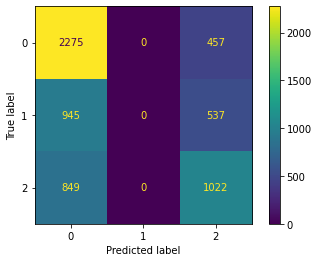

/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/1795329321.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/1795329321.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.548853644506533
Recall: 
 {0: 0.8301765943819197, 1: 0.0, 2: 0.5727843871140222} 
Precision: 
 {0: 0.5599925935069745, 1: nan, 2: 0.5266715830875123} 
F1-score: 
 {0: 0.6688290147801409, 1: nan, 2: 0.5487609656143946}


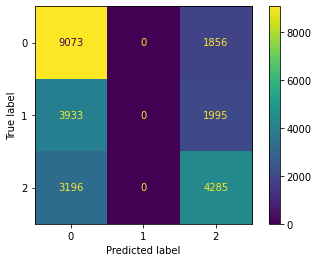

In [48]:
y_test_pred = model_2.predict([XH_test, XA_test, XG_test, players_test, best_test]).argmax(axis=-1)
y_train_pred = model_2.predict([XH_train, XA_train, XG_train, players_train, best_train]).argmax(axis=-1)


cm_metrics(y_test,y_test_pred, [0,1,2])
cm_metrics(y_train,y_train_pred, [0,1,2])

In [49]:
model_2.save('../data/models/hagpb')

INFO:tensorflow:Assets written to: ../data/models/hagpb/assets


INFO:tensorflow:Assets written to: ../data/models/hagpb/assets


# model 3

In [33]:
try:
    home_history.drop(columns=['home_id'], inplace = True)
except:
    pass
try:
    away_history.drop(columns=['away_id'], inplace = True)
except:
    pass
try:
    game_history.drop(columns=['game_history_id'], inplace = True)
except:
    pass

home_mean = home_history.groupby('game_id').mean().reset_index()
away_mean = away_history.groupby('game_id').mean().reset_index()
game_mean = game_history.groupby('game_id').mean().reset_index()

home_mean['exists'] = 1
away_mean['exists'] = 1
game_mean['exists'] = 1

home_mean = pd.merge(train_df[['game_id']],home_mean, how = 'left', on = 'game_id')
away_mean = pd.merge(train_df[['game_id']],away_mean, how = 'left', on = 'game_id')
game_mean = pd.merge(train_df[['game_id']],game_mean, how = 'left', on = 'game_id')

home_mean.loc[home_mean.H_goals.isnull(),home_mean.columns[1:]] = 0
away_mean.loc[away_mean.A_goals.isnull(),away_mean.columns[1:]] = 0
game_mean.loc[game_mean.H_goals.isnull(),game_mean.columns[1:]] = 0


In [34]:
y = train_df.Home_result.values

best_players = train_best.drop(columns=['game_id']).to_numpy()
players = train_df.drop(columns = ['game_id', 'Home_result']).to_numpy()
home_mean = home_mean.iloc[:,1:].to_numpy()
away_mean = away_mean.iloc[:,1:].to_numpy()
game_mean = game_mean.iloc[:,1:].to_numpy()


XH_train, XH_test, XA_train, XA_test, XG_train, XG_test, best_train, best_test, players_train, players_test, y_train, y_test = \
    train_test_split(home_mean, away_mean, game_mean, best_players, players, y, test_size = 0.2, random_state=0, stratify=y)

In [173]:
train_generator3 = DataGenerator(XH_train, XA_train, XG_train, best_train, players_train, y_train, batch_size = 128)
val_generator3 =   DataGenerator(XH_test,  XA_test,  XG_test,  best_test,  players_test,  y_test,  batch_size = 32)


In [95]:
for x in next(iter(train_generator3))[0]:
    print(x.shape, end = ' ')

(128, 6) (128, 6) (128, 8) (128, 192) (128, 144) 

In [154]:

home_input = tf.keras.Input(shape = (6) , name = 'home_train_input')                                   #input 1
Dense1 = tf.keras.layers.Dense(32,'relu', kernel_regularizer=L1L2(l1=0.0001, l2=0.0001),name='Dense1')(home_input)
Dense1 = tf.keras.layers.Dropout(0.2)(Dense1)


away_input = tf.keras.Input(shape = (6), name = 'away_train_input')                                   #input 2
Dense2 = tf.keras.layers.Dense(32,'relu', kernel_regularizer=L1L2(l1=0.0001, l2=0.0001),name='Dense2')(away_input)
Dense2 = tf.keras.layers.Dropout(0.2)(Dense2)


game_input = tf.keras.Input(shape = (8), name = 'game_train_input')                                   #input 3
Dense3 = tf.keras.layers.Dense(32,'relu', kernel_regularizer=L1L2(l1=0.0001, l2=0.0001),name='Dense3')(game_input)
Dense3 = tf.keras.layers.Dropout(0.2)(Dense3)



#Dense3 = tf.keras.layers.Dense(64,'relu',name='Dense3')(h_a_g)
#Dense3 = tf.keras.layers.Dropout(0.125)(Dense3)

#players
player_input = tf.keras.Input(shape = (192), name = 'player_input')  
Dense4 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.0001, l2=0.0001),name='Dense4')(player_input)
Dense4 = tf.keras.layers.Dropout(0.2)(Dense4)


#best_players
best_player_input = tf.keras.Input(shape = (144), name = 'best_player_input')  
Dense5 = tf.keras.layers.Dense(64,'relu', kernel_regularizer=L1L2(l1=0.0001, l2=0.0001),name='Dense5')(best_player_input)
Dense5 = tf.keras.layers.Dropout(0.2)(Dense5)


#final concat

h_a_g_p = tf.keras.layers.Concatenate()([Dense1, Dense2, Dense3, Dense4, Dense5])
Dense6 = tf.keras.layers.Dense(128,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense6')(h_a_g_p)
Dense6 = tf.keras.layers.Dropout(0.2)(Dense6)
Dense7 = tf.keras.layers.Dense(32,'relu', kernel_regularizer=L1L2(l1=0.001, l2=0.001),name='Dense7')(Dense6)
Dense7 = tf.keras.layers.Dropout(0.2)(Dense7)




Dense_output = tf.keras.layers.Dense(2, 'softmax', name='output')(Dense7)

In [155]:
model_4 = tf.keras.Model(inputs=[home_input,away_input,game_input,player_input,best_player_input], outputs=Dense_output)

opt = Adam(0.00005)
loss = SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
model_4.compile(optimizer=opt, loss=loss, metrics = [metric])

In [151]:
wandb.init(project="foot_LSTM_AVGplayers", entity="padda")

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▇▇▇▇████████████████
val_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,20
best_val_loss,0.88414
epoch,20
loss,0.91045
sparse_categorical_accuracy,0.75635
val_loss,0.88414


In [159]:
model_4.fit(
    train_generator3,
    epochs=30,
    validation_data=val_generator3,
    callbacks=[WandbCallback()]
)

Epoch 1/30
191/191 [==============================] - 1s 5ms/step - loss: 0.5797 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5775 - val_sparse_categorical_accuracy: 0.7565
Epoch 2/30
191/191 [==============================] - 1s 5ms/step - loss: 0.5789 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5763 - val_sparse_categorical_accuracy: 0.7565
Epoch 3/30
191/191 [==============================] - 1s 5ms/step - loss: 0.5776 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5750 - val_sparse_categorical_accuracy: 0.7565
Epoch 4/30
191/191 [==============================] - 1s 4ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5738 - val_sparse_categorical_accuracy: 0.7565
Epoch 5/30
191/191 [==============================] - 1s 4ms/step - loss: 0.5751 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.5729 - val_sparse_categorical_accuracy: 0.7565
Epoch 6/30
191/191 [==============================] - 1s 4ms/step - loss: 0.5740 - sparse_categorica

In [131]:
model_load = tf.keras.models.load_model('../data/models/hagpb_dense_only')


In [167]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = 0
  for i in range(len(cm)):
      accuracy = accuracy + cm[i][i]
    
  accuracy = accuracy/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

In [35]:
XH_test.shape

(6085, 6)

accuracy:  0.5460969597370583
Recall: 
 {0: 0.8294289897510981, 1: 0.0, 2: 0.5649385355424906} 
Precision: 
 {0: 0.5649463974071304, 1: nan, 2: 0.5096432015429122} 
F1-score: 
 {0: 0.6721044045676998, 1: nan, 2: 0.5358681875792142}


/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/839078852.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/839078852.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


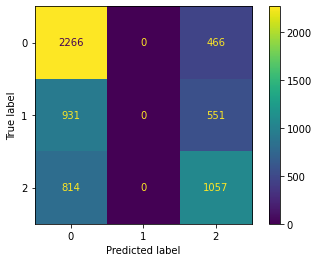

/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/839078852.py:5: RuntimeWarning: invalid value encountered in long_scalars
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
/var/folders/fw/vk6b0tfx7kvg_95mz0b5mts80000gn/T/ipykernel_1207/839078852.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}


accuracy:  0.5630290081354261
Recall: 
 {0: 0.8309085918199286, 1: 0.0, 2: 0.617831840663013} 
Precision: 
 {0: 0.5770843924758515, 1: nan, 2: 0.5373169030458033} 
F1-score: 
 {0: 0.6811175698481154, 1: nan, 2: 0.5747683889821551}


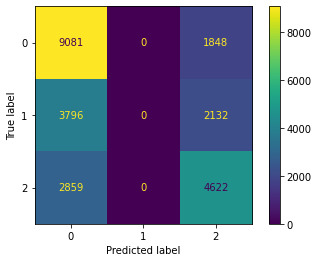

In [174]:
y_test_pred = model_load.predict([XH_test, XA_test, XG_test, players_test, best_test]).argmax(axis=-1)
y_train_pred = model_load.predict([XH_train, XA_train, XG_train, players_train, best_train]).argmax(axis=-1)


cm_metrics(y_test,y_test_pred, [0,1,2])
cm_metrics(y_train,y_train_pred, [0,1,2])

In [207]:
df.loc[df.diff2_0>=0.1,'y'].value_counts().sum()

6661

In [228]:
y_test_pred = model_load.predict([XH_test, XA_test, XG_test, players_test, best_test])
df = pd.DataFrame(y_test_pred)
df['y']=y_test

df["diff2_0"] = df.loc[:,2]-df.loc[:,0]

print('away wins')
for i in np.arange(0,0.9,0.1):
    try:
        V_C = df.loc[(df.diff2_0>=i) & (df.diff2_0<=(i+0.1)) ,'y'].value_counts()
        acc = V_C[2]/V_C.sum()
        print(f"accuracy for diff {i:.1f} to {i+0.1:.1f} : {acc:.3f}, for {V_C.sum()} games")
    except:
        pass

print()
print('home wins')
for i in np.arange(0,0.9,0.1):
    
    try:
        V_C = df.loc[(df.diff2_0<=-i) & (df.diff2_0>=(-i-0.1)),'y'].value_counts()
        acc = V_C[0]/V_C.sum()
        print(f"accuracy for diff {i:.1f} to {i+0.1:.1f} : {acc:.3f}, for {V_C.sum()} games")
    except:
        pass




away wins
accuracy for diff 0.0 to 0.1 : 0.403, for 484 games
accuracy for diff 0.1 to 0.2 : 0.438, for 434 games
accuracy for diff 0.2 to 0.3 : 0.462, for 338 games
accuracy for diff 0.3 to 0.4 : 0.541, for 305 games
accuracy for diff 0.4 to 0.5 : 0.626, for 219 games
accuracy for diff 0.5 to 0.6 : 0.713, for 181 games
accuracy for diff 0.6 to 0.7 : 0.774, for 84 games
accuracy for diff 0.7 to 0.8 : 0.714, for 28 games

home wins
accuracy for diff 0.0 to 0.1 : 0.378, for 558 games
accuracy for diff 0.1 to 0.2 : 0.445, for 623 games
accuracy for diff 0.2 to 0.3 : 0.479, for 629 games
accuracy for diff 0.3 to 0.4 : 0.592, for 622 games
accuracy for diff 0.4 to 0.5 : 0.608, for 564 games
accuracy for diff 0.5 to 0.6 : 0.679, for 430 games
accuracy for diff 0.6 to 0.7 : 0.771, for 345 games
accuracy for diff 0.7 to 0.8 : 0.881, for 194 games
accuracy for diff 0.8 to 0.9 : 0.800, for 45 games


In [230]:
for i in np.arange(-0.9,0.9,0.1):
    
    try:
        V_C = df.loc[(df.diff2_0>=i) & (df.diff2_0<=(i+0.1)),'y'].value_counts()
        acc = V_C[1]/V_C.sum()
        print(f"accuracy for diff {i:.1f} to {i+0.1:.1f} : {acc:.3f}, for {V_C.sum()} games")
    except:
        pass

accuracy for diff -0.9 to -0.8 : 0.156, for 45 games
accuracy for diff -0.8 to -0.7 : 0.082, for 194 games
accuracy for diff -0.7 to -0.6 : 0.128, for 345 games
accuracy for diff -0.6 to -0.5 : 0.212, for 430 games
accuracy for diff -0.5 to -0.4 : 0.239, for 564 games
accuracy for diff -0.4 to -0.3 : 0.233, for 622 games
accuracy for diff -0.3 to -0.2 : 0.280, for 629 games
accuracy for diff -0.2 to -0.1 : 0.242, for 623 games
accuracy for diff -0.1 to -0.0 : 0.297, for 558 games
accuracy for diff -0.0 to 0.1 : 0.287, for 484 games
accuracy for diff 0.1 to 0.2 : 0.313, for 434 games
accuracy for diff 0.2 to 0.3 : 0.278, for 338 games
accuracy for diff 0.3 to 0.4 : 0.275, for 305 games
accuracy for diff 0.4 to 0.5 : 0.205, for 219 games
accuracy for diff 0.5 to 0.6 : 0.182, for 181 games
accuracy for diff 0.6 to 0.7 : 0.167, for 84 games
accuracy for diff 0.7 to 0.8 : 0.179, for 28 games
accuracy for diff 0.8 to 0.9 : 1.000, for 1 games


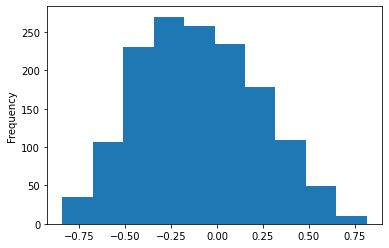

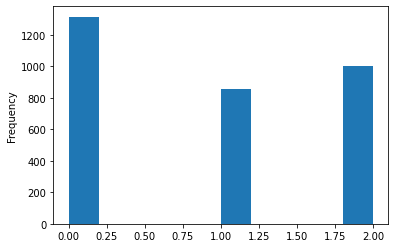

In [229]:
df.loc[df.y==1,'diff2_0'].plot.hist()
plt.show()
df.loc[(df.loc[:,1]>0.25) & (df.loc[:,1]<0.3),'y'].plot.hist()
plt.show()

In [112]:
model_3.save('../data/models/hagpb_dense_only')

INFO:tensorflow:Assets written to: ../data/models/hagpb_dense_only/assets


INFO:tensorflow:Assets written to: ../data/models/hagpb_dense_only/assets


# MLPC

In [118]:
Xtrain = np.concatenate((XH_train, XA_train, XG_train, best_train, players_train), axis = 1)
Xtest = np.concatenate((XH_test, XA_test, XG_test, best_test, players_test), axis = 1)

In [120]:
from sklearn.neural_network import MLPClassifier

In [126]:
MLPC = MLPClassifier((256,128,32),solver = 'lbfgs',learning_rate_init=0.001,max_iter=500, alpha = 0.001)

In [127]:
MLPC.fit(Xtrain,y_train)

/Users/pierreadda/opt/anaconda3/envs/foot_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 32), max_iter=500,
              solver='lbfgs')

accuracy:  0.5267050123253904
Recall: 
 {0: 0.8027086383601757, 1: 0.043859649122807015, 2: 0.5061464457509354} 
Precision: 
 {0: 0.556175500887649, 1: 0.2674897119341564, 2: 0.4986835176408636} 
F1-score: 
 {0: 0.6570786516853933, 1: 0.0753623188405797, 2: 0.5023872679045093}


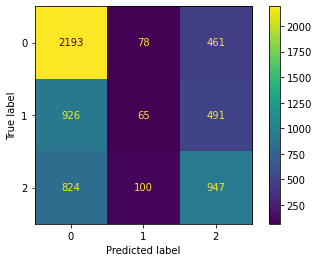

accuracy:  0.554359437916016
Recall: 
 {0: 0.8098636654771708, 1: 0.060560053981106615, 2: 0.5723833712070578} 
Precision: 
 {0: 0.5708481135117704, 1: 0.3927789934354486, 2: 0.5407248389948226} 
F1-score: 
 {0: 0.6696678520087767, 1: 0.10494007600116925, 2: 0.5561038961038961}


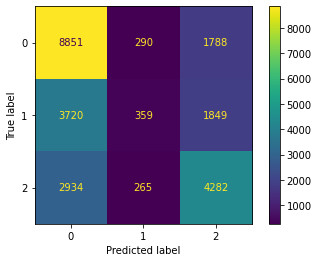

In [128]:
y_test_pred = MLPC.predict(Xtest)
y_train_pred = MLPC.predict(Xtrain)


cm_metrics(y_test,y_test_pred, [0,1,2])
cm_metrics(y_train,y_train_pred, [0,1,2])